In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import shapiro
from scipy.special import boxcox1p
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# Silent Warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
df=pd.read_csv('../../data/df_vars_modeling_dpto_final.csv')
df

,anio,codigo_departamento,codigo_entidad,promedio_del_componente_de_gestion_por_departamento_y_nacion,promedio_del_componente_de_resultados_por_departamento_y_nacion,participacion_de_las_actividades_economicas_del_pib_departamental_en_las_actividades_economicas_del_nacional_-_actividades_artisticas;_de_entrenamiento_y_otros_servicios_(actividades_artisticas;_de_entretenimiento_y_recreacion_y_otras_actividades_de_servicios;_actividades_de_los_hogares_individuales_en_calidad_de_empleadores;_actividades_no_diferenciadas_de_los_hogares_individuales_como_productores_de_bienes_y_servicios_para_uso_propio),pib_per_capita,pib_per_capita_como_porcentaje_del_promedio_nacional,pib_por_actividades_economicas_-_agricultura;_ganaderia;_caza;_silvicultura_y_pesca_(agricultura;_ganaderia;_caza;_silvicultura_y_pesca),pib_por_actividades_economicas_-_explotacion_de_minas_y_canteras_(explotacion_de_minas_y_canteras),porcentaje_del_pib_por_actividades_economicas_-_actividades_artisticas;_de_entrenamiento_y_otros_servicios_(actividades_artisticas;_de_entretenimiento_y_recreacion_y_otras_actividades_de_servicios;_actividades_de_los_hogares_individuales_en_calidad_de_empleadores;_actividades_no_diferenciadas_de_los_hogares_individuales_como_productores_de_bienes_y_servicios_para_uso_propio),porcentaje_del_pib_por_actividades_economicas_-_actividades_financieras_y_de_seguros_(actividades_financieras_y_de_seguros),porcentaje_del_pib_por_actividades_economicas_-_actividades_inmobiliarias_(actividades_inmobiliarias),porcentaje_del_pib_por_actividades_economicas_-_actividades_profesionales_(actividades_profesionales;_cientificas_y_tecnicas;_actividades_de_servicios_administrativos_y_de_apoyo),porcentaje_del_pib_por_actividades_economicas_-_administracion_publica_y_defensa_(administracion_publica_y_defensa;_planes_de_seguridad_social_de_afiliacion_obligatoria;_educacion;_actividades_de_atencion_de_la_salud_humana_y_de_servicios_sociales),porcentaje_del_pib_por_actividades_economicas_-_agricultura;_ganaderia;_caza;_silvicultura_y_pesca_(agricultura;_ganaderia;_caza;_silvicultura_y_pesca),porcentaje_del_pib_por_actividades_economicas_-_comercio_(comercio_al_por_mayor_y_al_por_menor;_reparacion_de_vehiculos_automotores_y_motocicletas;_transporte_y_almacenamiento;_alojamiento_y_servicios_de_comida),porcentaje_del_pib_por_actividades_economicas_-_construccion_(construccion),porcentaje_del_pib_por_actividades_economicas_-_electricidad;_gas;_vapor_y_saneamiento_ambiental_(suministro_de_electricidad;_gas;_vapor_y_aire_acondicionado;_distribucion_de_agua;_evacuacion_y_tratamiento_de_aguas_residuales;_gestion_de_desechos_y_actividades_de_saneamiento_ambiental),porcentaje_del_pib_por_actividades_economicas_-_explotacion_de_minas_y_canteras_(explotacion_de_minas_y_canteras),porcentaje_del_pib_por_actividades_economicas_-_impuestos_(impuestos),porcentaje_del_pib_por_actividades_economicas_-_industrias_manufactureras_(industrias_manufactureras),porcentaje_del_pib_por_actividades_economicas_-_informacion_y_comunicaciones_(informacion_y_comunicaciones),cobertura_bruta_en_educacion_-_total,cobertura_bruta_en_educacion_media,cobertura_bruta_en_educacion_primaria,cobertura_bruta_en_transicion,cobertura_en_educacion_superior,cobertura_neta_en_transicion,puntaje_promedio_pruebas_saber_11_-_lectura_critica,tasa_de_desercion_intra-anual_del_sector_oficial_en_educacion_basica_y_media_(desde_transicion_hasta_once),tasa_de_repitencia_del_sector_oficial_en_educacion_basica_y_media_(desde_transicion_hasta_once),penetracion_de_banda_ancha,tasa_de_violencias_basadas_en_genero,afiliados_al_regimen_subsidado,mortalidad_en_menores_de_5_anios_por_infeccion_respiratoria_aguda_(ira),porcentaje_de_nacidos_vivos_con_4_o_mas_consultas_de_control_prenatal,porcentaje_de_nacidos_vivos_con_bajo_peso_al_nacer,porcentaje_de_nacidos_vivos_hijos_de_mujeres_de_14_a_17_anios,porcentaje_de_nacidos_vivos_hijos_de_mujeres_de_18_a_26_anios,porcentaje_de_nacidos_vivos_hijos_de_mujeres_menores_de_14_anios,tas

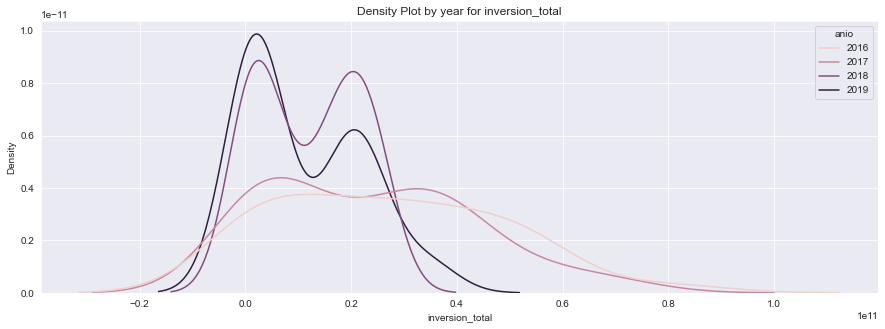

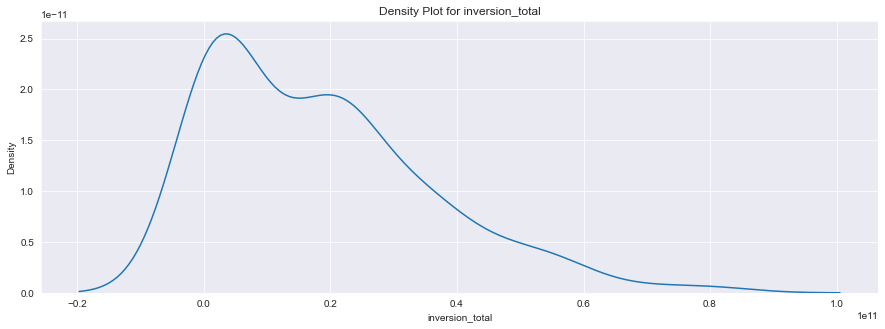

In [3]:
# Configuración del display de seaborn.

sns.set_style('darkgrid')
for col in ['inversion_total']:
    
    # Se genera un gráfico de densidad discriminando por año por año.
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.kdeplot(x = col, hue = 'anio', data = df)
    plt.title(f'Density Plot by year for {col}')
    plt.show()
    
    # Se genera un gráfico de densidad con los datos sin discriminar.
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.kdeplot(x = col, data = df)
    plt.title(f'Density Plot for {col}')
    plt.show()


In [4]:
# Just to remove any non-alpha-numeric characters from the column names
dict_ = {'-':'_', '.':'', '(':'', ')':'', ';':'', ':':'', '%':'porcentaje'}
new_cols = []
for col in df.columns:
    new_col = []
    new_col.append([dict_.get(char, char) for char in col])
    new_col = ''.join(new_col[0])
    new_cols.append(new_col)
new_cols[-5:]

['mdm',
 'conectividad',
 'transformacion',
 'inversion_total',
 'vacunacion_pentavalente_0_1_mean']

In [5]:
df.columns = new_cols

In [6]:
def min_max_standarize(feature, new_min=0, new_max=1):
    new_feature = [
        new_min + (x - feature.min())*(new_max - new_min) / (feature.max() - feature.min()) for x in feature
    ]
    return pd.Series(new_feature)

In [7]:
df.describe().transpose()[df.describe().transpose()['min']<0].index

Index(['capacidad_de_ahorro', 'deficit_o_superavit_total',
       'recursos_del_balance_y_variacion_de_depositos'],
      dtype='object')

In [8]:
new_min_max_cols = []
for col in df.describe().transpose()[df.describe().transpose()['min']<0].index:
    new_min_max_cols.append(min_max_standarize(df[col], 0.0001, 1))

In [9]:
df_no_negatives = pd.concat([df,pd.DataFrame({'capacidad_de_ahorro_0_1': new_min_max_cols[0],
    'deficit_o_superavit_total_0_1': new_min_max_cols[1],
    'recursos_del_balance_y_variacion_de_depositos_0_1': new_min_max_cols[2]
    })], axis=1).drop(columns=['recursos_del_balance_y_variacion_de_depositos', 'capacidad_de_ahorro', 'deficit_o_superavit_total'])

In [24]:
# Let's see for normality test and do box-cox transformation on non-normal variables:
def normalization_test_transformation(df):
    '''
    This function takes a pandas.DataFrame as input and runs Shapiro test of normality for every column if it is int64 or float64 dtype. 
    If the Shapiro test gives a p-value lower than 0.05 we reject the null hypothesis of normality and proceed to do a Box-Cox transformation. 
    The function returns a table with the p-values of the Shapiro test for each column, whether or not it is considered normally distributed and the lambda value of the Box-Cox transformation
    in case the column was not normally distributed. 
    It also returns a transformed DataFrame with the Box-Cox transformation applied to the non-normal columns and the original column if it was already normal. 
    
    All the numeric columns need to be positive as the Box-Cox transformation only works on positive values.

    '''    
    features = []
    shap_pvals = []
    normal = []
    lambda_ = []
    transformed_vars = []
    for feature in df.columns:
        if df[feature].dtype in ['int64', 'float64']:
            features.append(feature)
            shap_pvals.append(shapiro(df[feature])[1])
            if shapiro(df[feature])[1] < 0.05:
                pos_data = []
                for i in range(len(df[feature])):
                    if df[feature].iloc[i]==0:
                        pos_data.append(0.0001)
                    else:
                        pos_data.append(df[feature].iloc[i])
                transformed_feature, lambda_value = stats.boxcox(pos_data)
                lambda_.append(lambda_value)
                transformed_vars.append(transformed_feature)
                normal.append('No')
            else:
                lambda_.append(np.nan)
                transformed_vars.append(list(df[feature]))
                normal.append('Yes')
        else:
            transformed_vars.append(list(df[feature]))
            
    normality = pd.DataFrame({'Feature':features, 'Shapiro p-val': shap_pvals, 'Normal':normal, 'Box-cox lambda':lambda_})
    df_transformed = pd.DataFrame(transformed_vars).transpose()
    df_transformed.columns = df.columns
    return normality, df_transformed

normality, df_transformed = normalization_test_transformation(df_no_negatives)
df_transformed['anio'] = df_no_negatives['anio']
df_transformed['codigo_departamento'] = df_no_negatives['codigo_departamento']
df_transformed['codigo_entidad'] = df_no_negatives['codigo_entidad']

In [27]:
normality[normality['Normal']=='No']

,Feature,Shapiro p-val,Normal,Box-cox lambda
0,anio,5.130421e-10,No,0.679246
1,codigo_departamento,2.873059e-07,No,0.612757
2,codigo_entidad,2.873187e-07,No,0.612755
4,promedio_del_componente_de_resultados_por_depa...,9.363816e-09,No,7.372449
23,cobertura_bruta_en_educacion___total,3.912618e-05,No,3.556072
24,cobertura_bruta_en_educacion_media,6.140758e-08,No,2.762807
28,cobertura_neta_en_transicion,1.279381e-04,No,2.102405
30,tasa_de_desercion_intra_anual_del_sector_ofici...,6.343968e-06,No,0.180669
31,tasa_de_repitencia_del_sector_oficial_en_educa...,6.954254e-10,No,0.201882
32,penetracion_de_banda_ancha,1.640908e-04,No,0.544573


In [26]:
df_transformed_2018 = df_transformed[df_transformed['anio']<2019]
df_transformed_2018.head(10)

,anio,codigo_departamento,codigo_entidad,promedio_del_componente_de_gestion_por_departamento_y_nacion,promedio_del_componente_de_resultados_por_departamento_y_nacion,participacion_de_las_actividades_economicas_del_pib_departamental_en_las_actividades_economicas_del_nacional___actividades_artisticas_de_entrenamiento_y_otros_servicios_actividades_artisticas_de_entretenimiento_y_recreacion_y_otras_actividades_de_servicios_actividades_de_los_hogares_individuales_en_calidad_de_empleadores_actividades_no_diferenciadas_de_los_hogares_individuales_como_productores_de_bienes_y_servicios_para_uso_propio,pib_per_capita,pib_per_capita_como_porcentaje_del_promedio_nacional,pib_por_actividades_economicas___agricultura_ganaderia_caza_silvicultura_y_pesca_agricultura_ganaderia_caza_silvicultura_y_pesca,pib_por_actividades_economicas___explotacion_de_minas_y_canteras_explotacion_de_minas_y_canteras,porcentaje_del_pib_por_actividades_economicas___actividades_artisticas_de_entrenamiento_y_otros_servicios_actividades_artisticas_de_entretenimiento_y_recreacion_y_otras_actividades_de_servicios_actividades_de_los_hogares_individuales_en_calidad_de_empleadores_actividades_no_diferenciadas_de_los_hogares_individuales_como_productores_de_bienes_y_servicios_para_uso_propio,porcentaje_del_pib_por_actividades_economicas___actividades_financieras_y_de_seguros_actividades_financieras_y_de_seguros,porcentaje_del_pib_por_actividades_economicas___actividades_inmobiliarias_actividades_inmobiliarias,porcentaje_del_pib_por_actividades_economicas___actividades_profesionales_actividades_profesionales_cientificas_y_tecnicas_actividades_de_servicios_administrativos_y_de_apoyo,porcentaje_del_pib_por_actividades_economicas___administracion_publica_y_defensa_administracion_publica_y_defensa_planes_de_seguridad_social_de_afiliacion_obligatoria_educacion_actividades_de_atencion_de_la_salud_humana_y_de_servicios_sociales,porcentaje_del_pib_por_actividades_economicas___agricultura_ganaderia_caza_silvicultura_y_pesca_agricultura_ganaderia_caza_silvicultura_y_pesca,porcentaje_del_pib_por_actividades_economicas___comercio_comercio_al_por_mayor_y_al_por_menor_reparacion_de_vehiculos_automotores_y_motocicletas_transporte_y_almacenamiento_alojamiento_y_servicios_de_comida,porcentaje_del_pib_por_actividades_economicas___construccion_construccion,porcentaje_del_pib_por_actividades_economicas___electricidad_gas_vapor_y_saneamiento_ambiental_suministro_de_electricidad_gas_vapor_y_aire_acondicionado_distribucion_de_agua_evacuacion_y_tratamiento_de_aguas_residuales_gestion_de_desechos_y_actividades_de_saneamiento_ambiental,porcentaje_del_pib_por_actividades_economicas___explotacion_de_minas_y_canteras_explotacion_de_minas_y_canteras,porcentaje_del_pib_por_actividades_economicas___impuestos_impuestos,porcentaje_del_pib_por_actividades_economicas___industrias_manufactureras_industrias_manufactureras,porcentaje_del_pib_por_actividades_economicas___informacion_y_comunicaciones_informacion_y_comunicaciones,cobertura_bruta_en_educacion___total,cobertura_bruta_en_educacion_media,cobertura_bruta_en_educacion_primaria,cobertura_bruta_en_transicion,cobertura_en_educacion_superior,cobertura_neta_en_transicion,puntaje_promedio_pruebas_saber_11___lectura_critica,tasa_de_desercion_intra_anual_del_sector_oficial_en_educacion_basica_y_media_desde_transicion_hasta_once,tasa_de_repitencia_del_sector_oficial_en_educacion_basica_y_media_desde_transicion_hasta_once,penetracion_de_banda_ancha,tasa_de_violencias_basadas_en_genero,afiliados_al_regimen_subsidado,mortalidad_en_menores_de_5_anios_por_infeccion_respiratoria_aguda_ira,porcentaje_de_nacidos_vivos_con_4_o_mas_consultas_de_control_prenatal,porcentaje_de_nacidos_vivos_con_bajo_peso_al_nacer,porcentaje_de_nacidos_vivos_hijos_de_mujeres_de_14_a_17_anios,porcentaje_de_nacidos_vivos_hijos_de_mujeres_de_18_a_26_anios,porcentaje_de_nacidos_vivos_hijos_de_mujeres_menores_de_14_anios,tasa_de_fecundidad_especifica_en_mujeres_de_10_a_14_anios,tasa_de_fecundidad

In [13]:
print(list(df_transformed_2018.columns))

['anio', 'codigo_departamento', 'codigo_entidad', 'promedio_del_componente_de_gestion_por_departamento_y_nacion', 'promedio_del_componente_de_resultados_por_departamento_y_nacion', 'participacion_de_las_actividades_economicas_del_pib_departamental_en_las_actividades_economicas_del_nacional___actividades_artisticas_de_entrenamiento_y_otros_servicios_actividades_artisticas_de_entretenimiento_y_recreacion_y_otras_actividades_de_servicios_actividades_de_los_hogares_individuales_en_calidad_de_empleadores_actividades_no_diferenciadas_de_los_hogares_individuales_como_productores_de_bienes_y_servicios_para_uso_propio', 'pib_per_capita', 'pib_per_capita_como_porcentaje_del_promedio_nacional', 'pib_por_actividades_economicas___agricultura_ganaderia_caza_silvicultura_y_pesca_agricultura_ganaderia_caza_silvicultura_y_pesca', 'pib_por_actividades_economicas___explotacion_de_minas_y_canteras_explotacion_de_minas_y_canteras', 'porcentaje_del_pib_por_actividades_economicas___actividades_artisticas_de_

In [14]:
def results_summary_to_dataframe(results):
    '''
    This funciton takes the result of an statsmodel results table and transforms it into a dataframe, in order to better examine and compare the coefficients,
    p-values and confidence intervals.
    '''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"coeff":coeff,
                               "pvals":pvals,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })
    return results_df

In [102]:
y_2018 = df_transformed_2018['promedio_del_componente_de_resultados_por_departamento_y_nacion']
X_2018 = df_transformed_2018[['promedio_del_componente_de_gestion_por_departamento_y_nacion', 'participacion_de_las_actividades_economicas_del_pib_departamental_en_las_actividades_economicas_del_nacional___actividades_artisticas_de_entrenamiento_y_otros_servicios_actividades_artisticas_de_entretenimiento_y_recreacion_y_otras_actividades_de_servicios_actividades_de_los_hogares_individuales_en_calidad_de_empleadores_actividades_no_diferenciadas_de_los_hogares_individuales_como_productores_de_bienes_y_servicios_para_uso_propio', 'pib_per_capita', 'pib_per_capita_como_porcentaje_del_promedio_nacional', 'pib_por_actividades_economicas___agricultura_ganaderia_caza_silvicultura_y_pesca_agricultura_ganaderia_caza_silvicultura_y_pesca', 'pib_por_actividades_economicas___explotacion_de_minas_y_canteras_explotacion_de_minas_y_canteras', 'porcentaje_del_pib_por_actividades_economicas___actividades_artisticas_de_entrenamiento_y_otros_servicios_actividades_artisticas_de_entretenimiento_y_recreacion_y_otras_actividades_de_servicios_actividades_de_los_hogares_individuales_en_calidad_de_empleadores_actividades_no_diferenciadas_de_los_hogares_individuales_como_productores_de_bienes_y_servicios_para_uso_propio', 'porcentaje_del_pib_por_actividades_economicas___actividades_financieras_y_de_seguros_actividades_financieras_y_de_seguros', 'porcentaje_del_pib_por_actividades_economicas___actividades_inmobiliarias_actividades_inmobiliarias', 'porcentaje_del_pib_por_actividades_economicas___actividades_profesionales_actividades_profesionales_cientificas_y_tecnicas_actividades_de_servicios_administrativos_y_de_apoyo', 'porcentaje_del_pib_por_actividades_economicas___administracion_publica_y_defensa_administracion_publica_y_defensa_planes_de_seguridad_social_de_afiliacion_obligatoria_educacion_actividades_de_atencion_de_la_salud_humana_y_de_servicios_sociales', 'porcentaje_del_pib_por_actividades_economicas___agricultura_ganaderia_caza_silvicultura_y_pesca_agricultura_ganaderia_caza_silvicultura_y_pesca', 'porcentaje_del_pib_por_actividades_economicas___comercio_comercio_al_por_mayor_y_al_por_menor_reparacion_de_vehiculos_automotores_y_motocicletas_transporte_y_almacenamiento_alojamiento_y_servicios_de_comida', 'porcentaje_del_pib_por_actividades_economicas___construccion_construccion', 'porcentaje_del_pib_por_actividades_economicas___electricidad_gas_vapor_y_saneamiento_ambiental_suministro_de_electricidad_gas_vapor_y_aire_acondicionado_distribucion_de_agua_evacuacion_y_tratamiento_de_aguas_residuales_gestion_de_desechos_y_actividades_de_saneamiento_ambiental', 'porcentaje_del_pib_por_actividades_economicas___explotacion_de_minas_y_canteras_explotacion_de_minas_y_canteras', 'porcentaje_del_pib_por_actividades_economicas___impuestos_impuestos', 'porcentaje_del_pib_por_actividades_economicas___industrias_manufactureras_industrias_manufactureras', 'porcentaje_del_pib_por_actividades_economicas___informacion_y_comunicaciones_informacion_y_comunicaciones', 'cobertura_bruta_en_educacion___total', 'cobertura_bruta_en_educacion_media', 'cobertura_bruta_en_educacion_primaria', 'cobertura_bruta_en_transicion', 'cobertura_en_educacion_superior', 'tasa_de_desercion_intra_anual_del_sector_oficial_en_educacion_basica_y_media_desde_transicion_hasta_once', 'tasa_de_repitencia_del_sector_oficial_en_educacion_basica_y_media_desde_transicion_hasta_once', 'penetracion_de_banda_ancha', 'tasa_de_violencias_basadas_en_genero', 'afiliados_al_regimen_subsidado', 'mortalidad_en_menores_de_5_anios_por_infeccion_respiratoria_aguda_ira', 'porcentaje_de_nacidos_vivos_con_4_o_mas_consultas_de_control_prenatal', 'porcentaje_de_nacidos_vivos_con_bajo_peso_al_nacer', 'porcentaje_de_nacidos_vivos_hijos_de_mujeres_de_14_a_17_anios', 'porcentaje_de_nacidos_vivos_hijos_de_mujeres_de_18_a_26_anios', 'porcentaje_de_nacidos_vivos_hijos_de_mujeres_menores_de_14_anios', 'tasa_de_fecundidad_especifica_en_mujeres_de_10_a_14_anios', 'tasa_de_fecundidad_especifica_en_mujeres_de_10_a_19_anios', 'tasa_de_mortalidad_x_cada_1000_habitantes', 'tasa_de_mortalidad_infantil_en_menores_de_1_anio_x_cada_1000_nacidos_vivos', 'tasa_de_mortalidad_infantil_en_menores_de_5_anios_', 'porcentaje_de_ingresos_corrientes_destinados_a_funcionamiento', 'porcentaje_de_ingresos_corrientes_que_corresponden_a_recursos_propios', 'porcentaje_de_ingresos_que_corresponden_a_transferencias', 'porcentaje_del_gasto_total_destinado_a_inversion', 'gastos_totales_per_capita', 'indicador_de_desempenio_fiscal', 'ingresos_no_tributarios_per_capita', 'ingresos_per_capita_por_impuesto_a_la_industria_y_al_comercio', 'ingresos_per_capita_por_impuesto_predial', 'ingresos_tributarios_per_capita', 'intereses_de_deuda_publica', 'regalias_per_capita_valor_efectivamente_girado_al_municipio', 'transferencias_de_los_ingresos_corrientes', 'transferencias_per_capita_de_los_ingresos_corrientes', 'densidad_poblacional', 'poblacion_rural', 'porcentaje_de_hombres_mayores_de_edad', 'porcentaje_de_poblacion_de_hombres_de__20_24', 'porcentaje_de_poblacion_de_hombres_de__25_29', 'porcentaje_de_poblacion_de_hombres_de__30_34', 'porcentaje_de_poblacion_de_hombres_de__35_39', 'porcentaje_de_poblacion_de_hombres_de__45_49', 'porcentaje_de_poblacion_de_mujeres_de__25_29', 'porcentaje_poblacion_de_mujeres', 'conectividad', 'transformacion', 'inversion_total', 'capacidad_de_ahorro_0_1', 'deficit_o_superavit_total_0_1', 'recursos_del_balance_y_variacion_de_depositos_0_1']]

X_2018_tr, X_2018_te, y_2018_tr, y_2018_te = train_test_split(X_2018, y_2018, test_size = .25, random_state = 1337)

In [103]:
model_2018 = sm.OLS(y_2018_tr, sm.add_constant(X_2018_tr)).fit()
mse_2018 = mean_squared_error(y_2018_te, model_2018.predict(sm.add_constant(X_2018_te)))
print('AIC for model_2018 = ', model_2018.aic)
print('r-sqared for model_2018 = ', model_2018.rsquared)
print('MSE for model_2018', mse_2018)
print('RMSE for model_2018', mse_2018**0.5)
results_summary_to_dataframe(model_2018)[results_summary_to_dataframe(model_2018)['pvals']<0.1].sort_values(by='coeff', ascending=False)

AIC for model_2018 =  -960.9761853819871
r-sqared for model_2018 =  0.9972017987742945
MSE for model_2018 4.5673058096345234e-05
RMSE for model_2018 0.006758184526656936


,coeff,pvals,conf_lower,conf_higher


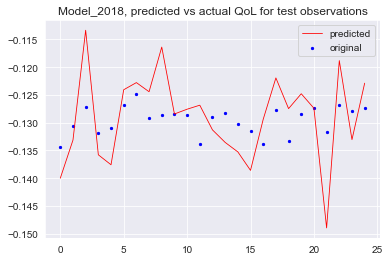

In [104]:
x_ax = range(len(X_2018_te))
plt.scatter(x_ax, y_2018_te, s=5, color="blue", label="original")
plt.plot(x_ax, model_2018.predict(sm.add_constant(X_2018_te)), lw=0.8, color="red", label="predicted")
plt.title('Model_2018, predicted vs actual QoL for test observations')
plt.legend()

In [105]:
# alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
alphas = np.logspace(-5, 1, 50)
elastic_cv=ElasticNetCV(l1_ratio=[.01, .1, .2, .25, .5, .7, .9, .95, .99, 1] ,alphas=alphas, cv=10, fit_intercept=True)
model_enet_cv = elastic_cv.fit(X_2018_tr, y_2018_tr)
print(model_enet_cv.alpha_)
print(model_enet_cv.l1_ratio_)

0.0006866488450042998
0.01


In [106]:
y_2018_pred = model_enet_cv.predict(X_2018_te)
score = model_enet_cv.score(X_2018_te, y_2018_te)
mse = mean_squared_error(y_2018_te, y_2018_pred)
print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
      .format(score, mse, np.sqrt(mse)))

R2:0.535, MSE:0.00, RMSE:0.00


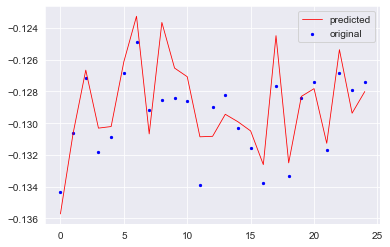

In [107]:
x_ax = range(len(X_2018_te))
plt.scatter(x_ax, y_2018_te, s=5, color="blue", label="original")
plt.plot(x_ax, y_2018_pred, lw=0.8, color="red", label="predicted")
plt.legend()

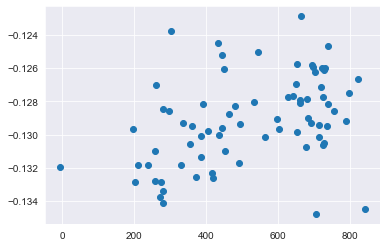

In [62]:
plt.scatter(x=X_2018_tr.transformacion,y=y_2018_tr)

# Model Using all variables with complete data for 2019:

In [19]:
df_transformed_2019 = df_transformed.drop(columns=df_transformed.describe().transpose()[df_transformed.describe().transpose()['count']<100].index)
df_transformed_2019.head(10)

,anio,codigo_departamento,codigo_entidad,promedio_del_componente_de_gestion_por_departamento_y_nacion,promedio_del_componente_de_resultados_por_departamento_y_nacion,cobertura_bruta_en_educacion___total,cobertura_bruta_en_educacion_media,cobertura_bruta_en_educacion_primaria,cobertura_bruta_en_transicion,cobertura_neta_en_transicion,tasa_de_desercion_intra_anual_del_sector_oficial_en_educacion_basica_y_media_desde_transicion_hasta_once,tasa_de_repitencia_del_sector_oficial_en_educacion_basica_y_media_desde_transicion_hasta_once,penetracion_de_banda_ancha,afiliados_al_regimen_subsidado,gastos_totales_per_capita,ingresos_no_tributarios_per_capita,ingresos_per_capita_por_impuesto_a_la_industria_y_al_comercio,ingresos_per_capita_por_impuesto_predial,ingresos_tributarios_per_capita,intereses_de_deuda_publica,regalias_per_capita_valor_efectivamente_girado_al_municipio,transferencias_de_los_ingresos_corrientes,transferencias_per_capita_de_los_ingresos_corrientes,densidad_poblacional,poblacion_rural,porcentaje_de_hombres_mayores_de_edad,porcentaje_de_poblacion_de_hombres_de__20_24,porcentaje_de_poblacion_de_hombres_de__25_29,porcentaje_de_poblacion_de_hombres_de__30_34,porcentaje_de_poblacion_de_hombres_de__35_39,porcentaje_de_poblacion_de_hombres_de__45_49,porcentaje_de_poblacion_de_mujeres_de__25_29,porcentaje_poblacion_de_mujeres,cobertura_media_neta,saber_11_matematicas,saber_11_lenguaje,cobertura_transicion,cobertura_salud,mortalidad_infantil,cobertura_electrica_rural,cobertura_internet,cobertura_acueducto,cobertura_alcantarillado,hurtos,hurtos_x_10000_hab,homicidios,homicidios_x_10000_hab,violencia_intrafamiliar,violencia_intrafamiliar_x_10000_hab,mdm,conectividad,transformacion,inversion_total,vacunacion_pentavalente_0_1_mean,deficit_o_superavit_total_0_1,recursos_del_balance_y_variacion_de_depositos_0_1
0,2016,5,299.859379,0.5358,-0.126635,3.868212e+06,72221.123183,108.88,75.25,2295.466815,1.719505,1.238272,6.369889,1311.195921,577.655801,48.595071,34.270572,3.300696,5.430924,11.029886,44.539594,13.509608,13.569402,4.980686,106.528843,8.469146e+06,0.535943,4.024231,69.232287,7.478586,8.463208,17.907137,1.222303e+06,-0.534782,4933.413776,47865.392220,-0.399575,-0.137061,1.328871,-0.053019,-1.850111,-0.385326,-0.560016,3.467551,2.696421,3.102180,2.219148,2.486219,1.947780,2.906688,193.019992,822.201086,10610.046502,-0.063295,-0.077501,-0.213782
1,2016,8,400.483103,0.4368,-0.126013,3.390683e+06,73285.647003,105.21,84.58,2035.451640,0.810202,0.211401,5.263436,1038.905108,551.266452,34.736183,31.378649,3.279708,5.382883,12.518578,40.734527,13.385959,13.246646,7.322134,57.137490,7.619390e+06,0.534390,3.983335,87.746583,8.402633,7.490985,15.905037,1.171705e+06,-0.451705,4631.895816,44482.035507,-0.379060,-0.149932,1.344032,-0.122282,-1.686668,-0.326597,-0.821869,3.681027,2.337802,3.761944,-0.060011,2.868883,1.468774,2.801297,163.185582,723.753893,8268.594538,-0.023569,-0.080643,-0.214662
2,2016,11,487.155636,0.4128,-0.134340,2.245113e+06,70334.682823,88.80,71.28,2285.228588,0.783030,1.507915,7.923562,987.060501,651.867499,62.498174,47.766152,3.341308,5.598804,29.921904,17.049276,30.004200,11.182838,9.738305,35.863922,9.291844e+06,0.532179,3.671850,87.746583,10.438188,9.613229,14.855090,1.267774e+06,-0.448314,7272.779342,65636.851184,-0.387099,-0.072148,1.258277,0.000000,-1.267241,-0.039995,-0.040147,4.936527,4.074567,10.359128,0.531278,3.757374,1.932842,3.092686,148.814419,793.701967,9035.105109,-0.040488,-0.094633,-0.234588
3,2016,13,539.809808,0.3887,-0.130116,3.795682e+06,55976.398178,112.11,97.89,2275.864621,1.202982,0.833200,3.795695,1061.189639,561.410333,34.103717,25.114992,3.217096,5.251877,9.165564,46.612237,12.777766,13.384493,4.716973,82.034276,6.324129e+06,0.539549,3.820365,54.536223,6.072713,6.516014,14.447355,1.119178e+06,-0.564465,4038.299509,38893.507831,-0.426703,-0.157033,1.370996,-0.215467,-1.098318,-0.431299,-0.870687,2.803831,1.051202,2.442314,0.254427,2.125680,1.036805,2.737233,183.879153,716.128556,8918.342779,

In [20]:
print(list(df_transformed_2019.columns))

['anio', 'codigo_departamento', 'codigo_entidad', 'promedio_del_componente_de_gestion_por_departamento_y_nacion', 'promedio_del_componente_de_resultados_por_departamento_y_nacion', 'cobertura_bruta_en_educacion___total', 'cobertura_bruta_en_educacion_media', 'cobertura_bruta_en_educacion_primaria', 'cobertura_bruta_en_transicion', 'cobertura_neta_en_transicion', 'tasa_de_desercion_intra_anual_del_sector_oficial_en_educacion_basica_y_media_desde_transicion_hasta_once', 'tasa_de_repitencia_del_sector_oficial_en_educacion_basica_y_media_desde_transicion_hasta_once', 'penetracion_de_banda_ancha', 'afiliados_al_regimen_subsidado', 'gastos_totales_per_capita', 'ingresos_no_tributarios_per_capita', 'ingresos_per_capita_por_impuesto_a_la_industria_y_al_comercio', 'ingresos_per_capita_por_impuesto_predial', 'ingresos_tributarios_per_capita', 'intereses_de_deuda_publica', 'regalias_per_capita_valor_efectivamente_girado_al_municipio', 'transferencias_de_los_ingresos_corrientes', 'transferencias_p

In [21]:
y_2019 = df_transformed_2019['promedio_del_componente_de_resultados_por_departamento_y_nacion']
X_2019 = df_transformed_2019[['promedio_del_componente_de_gestion_por_departamento_y_nacion', 'cobertura_bruta_en_educacion___total', 'cobertura_bruta_en_educacion_media', 'cobertura_bruta_en_educacion_primaria', 'cobertura_bruta_en_transicion', 'tasa_de_desercion_intra_anual_del_sector_oficial_en_educacion_basica_y_media_desde_transicion_hasta_once', 'tasa_de_repitencia_del_sector_oficial_en_educacion_basica_y_media_desde_transicion_hasta_once', 'penetracion_de_banda_ancha', 'afiliados_al_regimen_subsidado', 'gastos_totales_per_capita', 'ingresos_no_tributarios_per_capita', 'ingresos_per_capita_por_impuesto_a_la_industria_y_al_comercio', 'ingresos_per_capita_por_impuesto_predial', 'ingresos_tributarios_per_capita', 'intereses_de_deuda_publica', 'regalias_per_capita_valor_efectivamente_girado_al_municipio', 'transferencias_de_los_ingresos_corrientes', 'transferencias_per_capita_de_los_ingresos_corrientes', 'densidad_poblacional', 'poblacion_rural', 'porcentaje_de_hombres_mayores_de_edad', 'porcentaje_de_poblacion_de_hombres_de__20_24', 'porcentaje_de_poblacion_de_hombres_de__25_29', 'porcentaje_de_poblacion_de_hombres_de__30_34', 'porcentaje_de_poblacion_de_hombres_de__35_39', 'porcentaje_de_poblacion_de_hombres_de__45_49', 'porcentaje_de_poblacion_de_mujeres_de__25_29', 'porcentaje_poblacion_de_mujeres', 'conectividad', 'transformacion', 'inversion_total', 'deficit_o_superavit_total_0_1', 'recursos_del_balance_y_variacion_de_depositos_0_1']]

X_2019_tr, X_2019_te, y_2019_tr, y_2019_te = train_test_split(X_2019, y_2019, test_size = .2, random_state = 1337)

In [29]:
model_2019 = sm.OLS(y_2019_tr, sm.add_constant(X_2019_tr)).fit()
print('AIC for model_2019 = ', model_2019.aic)
print('r-sqared for model_2019 = ', model_2019.rsquared)
results_summary_to_dataframe(model_2019)[results_summary_to_dataframe(model_2019)['pvals']<0.1].sort_values(by='coeff', ascending=False)

AIC for model_2019 =  -1055.6934669084856
r-sqared for model_2019 =  0.8172124609289418


,coeff,pvals,conf_lower,conf_higher
recursos_del_balance_y_variacion_de_depositos_0_1,1.604230e-02,8.422634e-03,4.240053e-03,2.784455e-02
porcentaje_de_poblacion_de_hombres_de__25_29,7.238982e-03,3.470638e-03,2.465744e-03,1.201222e-02
tasa_de_desercion_intra_anual_del_sector_oficial_en_educacion_basica_y_media_desde_transicion_hasta_once,1.057109e-03,6.398767e-02,-6.310630e-05,2.177325e-03
cobertura_bruta_en_transicion,6.890195e-05,2.577071e-03,2.493486e-05,1.128690e-04
afiliados_al_regimen_subsidado,5.558544e-06,7.677883e-04,2.406234e-06,8.710854e-06
porcentaje_poblacion_de_mujeres,1.494590e-08,1.660790e-02,2.798993e-09,2.709280e-08
cobertura_bruta_en_educacion___total,1.831001e-09,5.426342e-03,5.582670e-10,3.103734e-09
poblacion_rural,-7.424815e-05,1.256392e-03,-1.183073e-04,-3.018900e-05
cobertura_bruta_en_educacion_primaria,-1.959084e-04,6.968069e-06,-2.763959e-04,-1.154209e-04
transferencias_de_los_ingresos_corrientes,-2.599904e-04,7.015477e-07,-3.551885e-04,-1.647924e-04


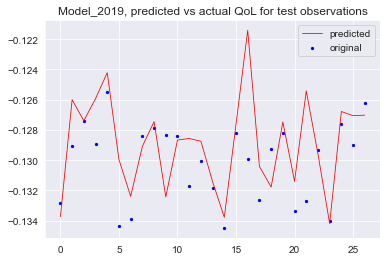

In [93]:
x_ax = range(len(X_2019_te))
plt.scatter(x_ax, y_2019_te, s=5, color="blue", label="original")
plt.plot(x_ax, model_2019.predict(sm.add_constant(X_2019_te)), lw=0.8, color="red", label="predicted")
plt.title('Model_2019, predicted vs actual QoL for test observations')
plt.legend()

In [87]:
alphas = np.logspace(-5, 1, 50)
elastic_cv=ElasticNetCV(l1_ratio=[.01, .1, .2, .25, .5, .7, .9, .95, .99, 1] ,alphas=alphas, cv=10, fit_intercept=True)
model_enet_cv_2019 = elastic_cv.fit(X_2019_tr, y_2019_tr)
print(model_enet_cv_2019.alpha_)
print(model_enet_cv_2019.l1_ratio_)

0.0009102981779915217
0.25


In [88]:
y_2019_pred = model_enet_cv_2019.predict(X_2019_te)
score = model_enet_cv_2019.score(X_2019_te, y_2019_te)
mse = mean_squared_error(y_2019_te, y_2019_pred)
print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
      .format(score, mse, np.sqrt(mse)))

R2:0.174, MSE:0.00, RMSE:0.00


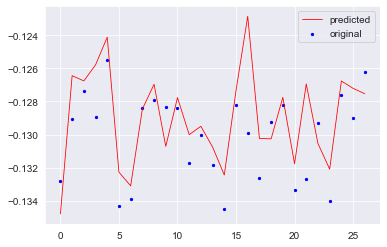

In [89]:
x_ax = range(len(X_2019_te))
plt.scatter(x_ax, y_2019_te, s=5, color="blue", label="original")
plt.plot(x_ax, y_2019_pred, lw=0.8, color="red", label="predicted")
plt.legend()